Done:
* Generate melspec and reconstruct audio using this [code](https://github.com/bkvogel/griffin_lim)
* [ ] For inference step, may use pretrained SEGAN to clean noise causes by Griffin-Lim
* [X] Reconstruct audio from spec that is audible using Griffin-Lim (it causes noise)
* [X] complete list of supported functions in this file + [whisper.ipynb](https://colab.research.google.com/drive/18N5IoCRQHvaHnz7mxpRgrtZfHHOUyxL0?usp=sharing)

In [ ]:
!pip install librosa -q

In [1]:
import os
import sys
import math
import time
import array

import librosa
import numpy as np
import pandas as pd
import scipy
import scipy.signal
import scipy.io.wavfile
from pylab import *
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio
from tqdm import tqdm

import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torchaudio.utils import download_asset

import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.random.manual_seed(0)
print(torch.__version__)
print(torchaudio.__version__)

2.0.1+cu118
2.0.2+cu118


In [2]:
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)
# SPEECH_WAVEFORM_lbs, SAMPLE_RATE_lbs = librosa.load(SAMPLE_SPEECH)
# SPEECH_WAVEFORM_lbs = torch.tensor(SPEECH_WAVEFORM_lbs).unsqueeze(0)
torchaudio.save('sample.wav', SPEECH_WAVEFORM.to(torch.float32), SAMPLE_RATE)
# SPEECH_WAVEFORM_lbs.shape, SPEECH_WAVEFORM.shape

100%|██████████| 106k/106k [00:00<00:00, 31.6MB/s]


(torch.Size([1, 74970]), torch.Size([1, 54400]))

## Util funcs

In [2]:
def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)

def plot_spectrogram_db(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(specgram, origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)

# TEST POWER TO DB IN TORCH TENSOR (instead of np array)
from typing import Callable, Optional, Union

def power_to_db(S, ref: Union[float, Callable] = 1.0, amin: float = 1e-10, top_db: Optional[float] = 80.0):
  # https://librosa.org/doc/latest/_modules/librosa/core/spectrum.html#power_to_db
  magnitude = S
  if callable(ref): # User supplied a function to calculate reference power
      ref_value = ref(magnitude)
  else:
      ref_value = torch.tensor(abs(ref))
  amin = torch.tensor(amin)
  log_spec = 10.0 * torch.log10(torch.maximum(amin, magnitude))
  log_spec -= 10.0 * torch.log10(torch.maximum(amin, ref_value))
  if top_db is not None:
    if top_db < 0: raise Exception("top_db must be non-negative")
    log_spec = torch.maximum(log_spec, log_spec.max() - top_db)
  return log_spec

def db_to_power(S_db, ref: float = 1.0):
  # https://librosa.org/doc/latest/_modules/librosa/core/spectrum.html#db_to_power
  return ref * torch.pow(torch.tensor(10.), 0.1 * S_db)

In [3]:
class Clean:
    def __init__(self, device):
        self.sample_rate = 16000
        self.device = device
        self.max_len = 64000 + 1280

    def clean_signal(self, wav, sr):
        wav = self.resample_if_necessary(wav, sr)
        wav = self.mix_down_if_necessary(wav)
        wav = self.pad_or_trim(wav)
        return wav

    def mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal

    def resample_if_necessary(self, signal, sr):
        if sr != self.sample_rate:
            resampler = T.Resample(sr, self.sample_rate).to(self.device)
            signal = resampler(signal)
        return signal

    def pad_or_trim(self, signal):
        # cut_if_necessary
        signal = signal[:, :min(signal.shape[1], self.max_len)]  # cut by time axis
        # pad_if_necessary, pad with 0
        num_missing_samples = max(0, self.max_len - signal.shape[1])
        signal = torch.nn.functional.pad(signal, (0, num_missing_samples), value=0)
        return signal

## Visualize sample

In [ ]:
plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform")
Audio(SPEECH_WAVEFORM.numpy(), rate=SAMPLE_RATE)

NameError: ignored

## Preprocess

### Resample, Reshape

Resample ([torch](https://pytorch.org/audio/stable/generated/torchaudio.transforms.Resample.html#torchaudio.transforms.Resample)/[librosa](https://librosa.org/doc/latest/generated/librosa.resample.html)): is need when *sample_rate* is not consistent among dataset or not same as `target_sample_rate` [1].

In [ ]:

# example from Youtube [1]
target_sample_rate = 25000

def _resample_if_necessary(signal, sr):
  if sr != target_sample_rate:
    resampler = torchaudio.transforms.Resample(sr, target_sample_rate)
    signal = resampler(signal)
  return signal

def _mix_down_if_necessary(self, signal):
  if signal.shape[0] > 1:
    signal = torch.mean(signal, dim=0, keepdim=True)
  return signal

### Padding Truncating

In [ ]:
# example from Youtube [1]
num_samples = 60000

def _cut_if_necessary(signal):
  if signal.shape[1] > num_samples:
    signal = signal[:, :num_samples]  # cut by time axis
  return signal

def _right_pad_if_necessary(signal):
  length_signal = signal.shape[1]
  if length_signal < num_samples:
    num_missing_samples = num_samples - length_signal
    last_dim_padding = (0, num_missing_samples)
    signal = torch.nn.functional.pad(signal, last_dim_padding)
  return signal

## Audio to Mel

In [ ]:
n_fft = 400
win_length = None
hop_length = 160
n_mels = 80
sample_rate = 16000
def log_mel_spectrogram(audio, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length):
    # https://github.com/openai/whisper/blob/main/whisper/audio.py#L110
    stft = torch.stft(audio, n_fft, hop_length, window=torch.hann_window(n_fft), return_complex=True)
    magnitudes = stft[..., :-1].abs() ** 2

    filters = librosa.filters.mel(sr=sample_rate, n_fft=n_fft, n_mels=n_mels)
    filters = torch.from_numpy(filters)
    mel_spec = filters @ magnitudes

    log_spec = torch.clamp(mel_spec, min=1e-10).log10()
    log_spec = torch.maximum(log_spec, log_spec.max() - 8.0)
    log_spec = (log_spec + 4.0) / 4.0
    return log_spec

/usr/local/lib/python3.10/dist-packages/torchaudio/transforms/_transforms.py:611: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


melspec.shape = torch.Size([1, 80, 341])


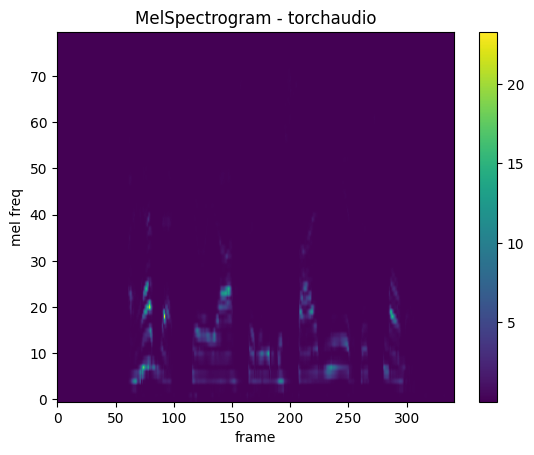

melspec_db.shape = torch.Size([1, 80, 341])


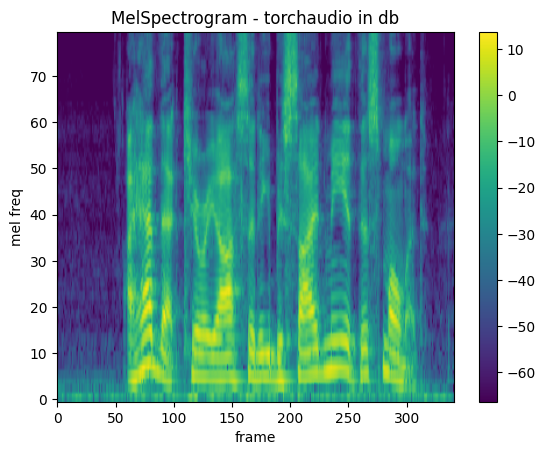

In [ ]:
# n_fft = 1024
# win_length = None
# hop_length = 512
# n_mels = 128
# sample_rate = 16000

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)
melspec = mel_spectrogram(SPEECH_WAVEFORM)  # melspec.shape = (1, h, w)
print('melspec.shape =', melspec.shape)
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")
melspec_db = torch.tensor(librosa.power_to_db(melspec))
print('melspec_db.shape =', melspec_db.shape)
plot_spectrogram(melspec_db[0], title="MelSpectrogram - torchaudio in db", ylabel="mel freq")

torch.Size([1, 80, 340])


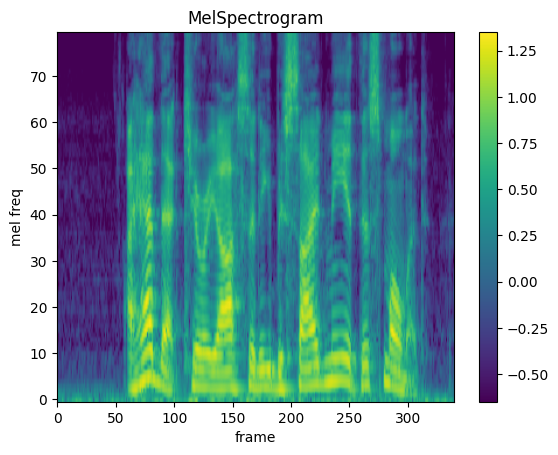

In [ ]:
log_spec = log_mel_spectrogram(SPEECH_WAVEFORM)
print(log_spec.shape)
plot_spectrogram(log_spec[0], title="MelSpectrogram", ylabel="mel freq")

melspec_librosa_db.shape = torch.Size([1, 80, 341])


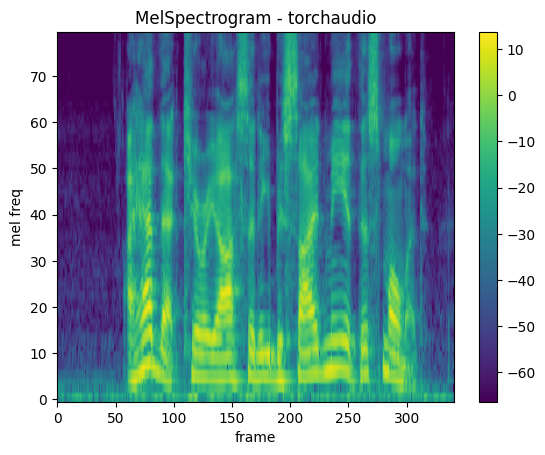

In [ ]:
melspec_librosa = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM.numpy(), # SPEECH_WAVEFORM.numpy().shape = (1, 54400)
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels=n_mels,
    norm="slaney",
    htk=True,
)
melspec_librosa = torch.tensor(melspec_librosa)
# print('melspec_librosa.shape =', melspec_librosa.shape)
# plot_spectrogram_db(melspec_librosa[0], title="MelSpectrogram - librosa", ylabel="mel freq")
melspec_librosa_db = torch.tensor(librosa.power_to_db(melspec_librosa))
print('melspec_librosa_db.shape =', melspec_librosa_db.shape)
plot_spectrogram(melspec_librosa_db[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

In [ ]:
print(type(melspec), type(melspec_librosa), type(melspec_db), type(melspec_librosa_db))
mse = torch.square(melspec - melspec_librosa).mean().item()
print("Mean Square Difference b/w torchaudio & librosa: ", mse)
mse_db = torch.square(melspec_db - melspec_librosa_db).mean().item()
print("Mean Square Difference b/w torchaudio & librosa: ", mse_db)

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
Mean Square Difference b/w torchaudio & librosa:  1.0166469445807569e-12
Mean Square Difference b/w torchaudio & librosa:  2.594623405016705e-10


In [ ]:
melspec = mel_spectrogram(SPEECH_WAVEFORM)  # melspec.shape = (1, h, w)
print('melspec.shape =', melspec.shape)
melspec_db = torch.from_numpy(librosa.power_to_db(melspec))
print('melspec_db.shape =', melspec_db.shape)
melspec_ = librosa.db_to_power(melspec_db)
(melspec - melspec_).sum()

melspec.shape = torch.Size([1, 80, 341])
melspec_db.shape = torch.Size([1, 80, 341])


tensor(-0.0003)

## Mel to Audio (reconstruct)

In [ ]:
sample_rate = 16000
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128
n_stft = int((n_fft//2) + 1)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [ ]:
mel_transform = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode='reflect',
    power=2.0,
    normalized=True,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
).to(device)
invers_transform = T.InverseMelScale(#sample_rate=sample_rate, n_stft=n_stft
    sample_rate=sample_rate,
    n_stft=n_stft,
    n_mels=n_mels,
    mel_scale='htk',
    max_iter=1000
).to(device)
grifflim_transform = T.GriffinLim(n_fft=n_fft, win_length=win_length, power=2.0).to(device)

# mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate, n_fft=n_fft).to(device)
# invers_transform = torchaudio.transforms.InverseMelScale(sample_rate=sample_rate, n_stft=n_stft, max_iter=1000).to(device) # max_iter=100000 DEFAULT
# grifflim_transform = torchaudio.transforms.GriffinLim(n_fft=n_fft).to(device)

/usr/local/lib/python3.10/dist-packages/torchaudio/transforms/_transforms.py:611: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


In [ ]:
# TEST POWER TO DB
waveform, sample_rate = SPEECH_WAVEFORM.detach().clone(), SAMPLE_RATE
waveform = waveform.to(device)

mel_specgram = mel_transform(waveform)
mel_specgram_inv = invers_transform(mel_specgram)
pseudo_waveform = grifflim_transform(mel_specgram_inv)

mel_specgram_db = power_to_db(mel_specgram)
mel_specgram_inv_db = invers_transform(db_to_power(mel_specgram_db))
pseudo_waveform_db = grifflim_transform(mel_specgram_inv_db)

pseudo_waveform.shape, pseudo_waveform_db.shape, (pseudo_waveform - pseudo_waveform_db).sum()

(torch.Size([1, 54272]),
 torch.Size([1, 54272]),
 tensor(1.1751, device='cuda:0'),
 True,
 False,
 False,
 False)

torch.Size([1, 128, 107])


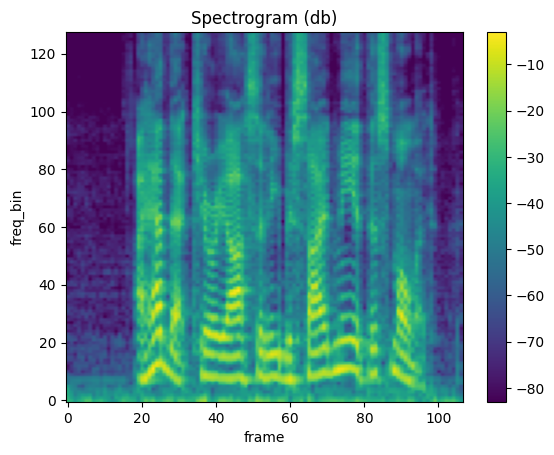

In [ ]:
waveform, sample_rate = SPEECH_WAVEFORM, SAMPLE_RATE
waveform = waveform.to(device)

mel_specgram = mel_transform(waveform)
print(mel_specgram.shape)
plot_spectrogram_db(mel_specgram[0].cpu())

In [ ]:
# TEST BATCH
waveform, sample_rate = SPEECH_WAVEFORM, SAMPLE_RATE
waveform_batch = torch.cat([waveform for _ in range(5)], dim=0).to(device)

mel_specgram_batch = mel_transform(waveform_batch)
mel_specgram_inv_batch = invers_transform(mel_specgram_batch)
pseudo_waveform_batch = grifflim_transform(mel_specgram_inv_batch)
waveform_batch.shape, mel_specgram_batch.shape, mel_specgram_inv_batch.shape, pseudo_waveform_batch.shape,

(torch.Size([5, 54400]),
 torch.Size([5, 128, 107]),
 torch.Size([5, 513, 107]),
 torch.Size([5, 54272]))

In [ ]:
def normalize_spec(melspec, minval=None, maxval=None):
  if (minval is None) and (maxval is None):
    maxval, minval = melspec.max(), melspec.min()
  melspec -= minval
  melspec /= (maxval - minval)
  return melspec, (minval, maxval)

def denormalize_spec(melspec, minval, maxval):
  melspec *= (maxval - minval)
  melspec += minval
  return melspec

In [ ]:
# TEST NORMALIZATION
mel_specgram_db_norm, minmaxval = normalize_spec(mel_specgram_db)
mel_specgram_db_denorm = denormalize_spec(mel_specgram_db_norm, *minmaxval)
pseudo_waveform_db_denorm = grifflim_transform(invers_transform(db_to_power(mel_specgram_db_denorm)))

(mel_specgram_db==mel_specgram_db_denorm).all(), (pseudo_waveform_db_denorm - pseudo_waveform_db).sum(), pseudo_waveform_db.shape

(tensor(True, device='cuda:0'),
 tensor(1.3679, device='cuda:0'),
 torch.Size([1, 54272]))

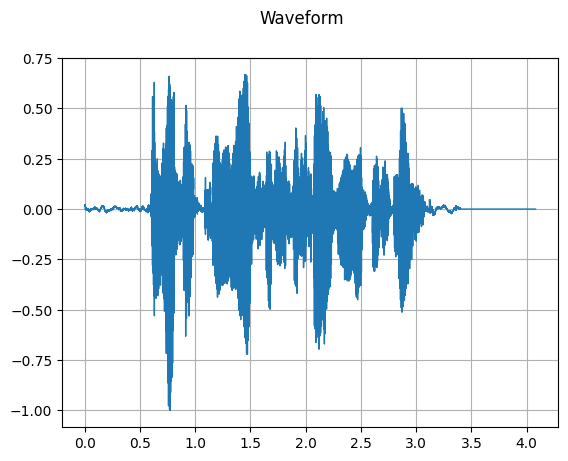

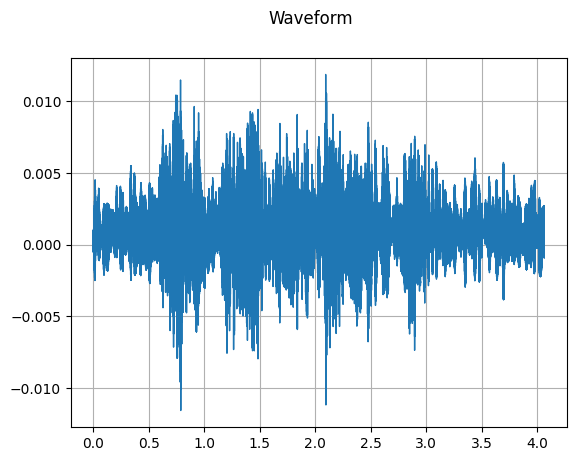

In [ ]:
# TEST COMBINE
waveform, sample_rate = SPEECH_WAVEFORM, SAMPLE_RATE
waveform = waveform.to(device)

cleaner = Clean(device)
waveform = cleaner.clean_signal(waveform, sample_rate)

# audio to spec
mel_specgram = mel_transform(waveform)
# to db spec
mel_specgram_db = power_to_db(mel_specgram)
# normalize spec
mel_specgram_db_norm, minmaxval = normalize_spec(mel_specgram_db)
# clip range 0-1
mel_specgram_db_norm_clamp = torch.clamp(mel_specgram_db_norm, min=0.0, max=1.0)
assert (mel_specgram_db_norm == mel_specgram_db_norm_clamp).all().item()
# denormalize spec
mel_specgram_db_denorm = denormalize_spec(mel_specgram_db_norm_clamp, *minmaxval)
# spec to power
mel_specgram_db_denorm_depower = db_to_power(mel_specgram_db_denorm)
# spec to audio
pseudo_waveform_db_denorm = grifflim_transform(invers_transform(mel_specgram_db_denorm_depower))

plot_waveform(waveform.cpu(), sample_rate)
plot_waveform(pseudo_waveform_db_denorm.cpu(), sample_rate)
plot_waveform(normalize_spec(pseudo_waveform_db_denorm.cpu())[0], sample_rate)

plot_spectrogram(power_to_db(mel_transform(waveform)).cpu()[0])
plot_spectrogram(power_to_db(mel_transform(pseudo_waveform_db_denorm)).cpu()[0]) # ~ plot_spectrogram(power_to_db(mel_transform(normalize_spec(pseudo_waveform_db_denorm)[0])).cpu()[0])

Audio(pseudo_waveform_db_denorm.cpu(), rate=sample_rate)

In [ ]:
pseudo_waveform_db_denorm.min()

tensor(-0.0116, device='cuda:0')

## Note

Aware that `SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)`, `SPEECH_WAVEFORM` can have many channels. Thus, after converting to Mel-spec, img.shape = (c, h, w).

References:
* [1]: Extracting Mel Spectrograms with Pytorch and Torchaudio - Valerio Velardo ([Youtube](https://www.youtube.com/watch?v=lhF_RVa7DLE&list=PL-wATfeyAMNoirN4idjev6aRu8ISZYVWm&index=5))
* [2]: Deep Learning for Audio Classification - Seth Adams ([Youtube](https://www.youtube.com/playlist?list=PLhA3b2k8R3t2Ng1WW_7MiXeh1pfQJQi_P))
* [3]: [A CRNN-GRU Based RL Approach to Audio Captioning](https://x-lance.sjtu.edu.cn/papers/2020/xnx98-xu-dcase2020.pdf)
* [4]: [Speech emotion recognition model based on Bi-GRU and Focal Loss](https://www.sciencedirect.com/science/article/pii/S0167865520304141)

## Github https://github.com/bkvogel/griffin_lim.git

In [5]:
!git clone https://github.com/bkvogel/griffin_lim.git

Cloning into 'griffin_lim'...
remote: Enumerating objects: 30, done.
remote: Total 30 (delta 0), reused 0 (delta 0), pack-reused 30
Receiving objects: 100% (30/30), 1020.91 KiB | 24.90 MiB/s, done.
Resolving deltas: 100% (10/10), done.


1. Add those 2 lines for center_freq_linear_bin, left_bin, and right_bin in `audio_utilities.py`
  ```python
    assert (left_bin - int(left_bin)) == 0.0
    left_bin = int(left_bin)
  ```
1. Change `audio_utilities.save_audio_to_file()` into:
  ```python
  soundfile.write('out1.wav', x_reconstruct, sample_rate_hz)
  ```


In [4]:
# general
in_file = 'sample.wav'
sample_rate_hz = 16000
fft_size = 1024 #2048
iterations = 10
enable_filter = False
enable_mel_scale = True
cutoff_freq = 1000
# run_demo()
min_freq_hz = 70
max_freq_hz = 8000
mel_bin_count = 128 #200

this_filterbank = this_mel_spectrogram = this_inverted_mel_to_linear_freq_spectrogram = 0

sample_rate = sample_rate_hz
n_fft = fft_size
win_length = None
hop_length = 512
n_mels = mel_bin_count
n_stft = int((n_fft//2) + 1)
device_ = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
!python run_demo.py --in_file bkvhi.wav --sample_rate_hz 44100 --enable_mel_scale

### griffin_lim/audio_utilities.py

#### torch batch

In [5]:
def get_signal_torch(in_file, expected_fs=44100):
    fs, y = scipy.io.wavfile.read(in_file)
    num_type = y[0].dtype
    if num_type == 'int16':
        y = y*(1.0/32768)
    elif num_type == 'int32':
        y = y*(1.0/2147483648)
    elif num_type == 'float32':
        pass # Nothing to do
    elif num_type == 'uint8':
        raise Exception('8-bit PCM is not supported.')
    else:
        raise Exception('Unknown format.')
    if fs != expected_fs:
        raise Exception('Invalid sample rate.')
    if y.ndim == 1:
        return torch.tensor(y)
    else:
        return torch.tensor(y.mean(axis=1))

def norm(x):
    # x.shape = (N, wav_lens)
    mi, ma = torch.min(x, dim=1, keepdim=True).values, torch.max(x, dim=1, keepdim=True).values
    x = x - mi
    x = x / (ma - mi)
    return x

def change_range(x):
    # x.shape = (N, wav_lens)
    # change range from 0 -> 1 to -1 -> 1
    x = x * 2.0
    x = x - 1.0
    return x

def hz_to_mel(f_hz):
    return 2595*torch.log10(torch.as_tensor(1.0 + f_hz/700.0))

def mel_to_hz(m_mel):
    return 700*(10**(m_mel/2595.0) - 1.0)

def fft_bin_to_hz(n_bin, sample_rate_hz, fft_size):
    n_bin = float(n_bin)
    sample_rate_hz = float(sample_rate_hz)
    fft_size = float(fft_size)
    return n_bin*sample_rate_hz/(2.0*fft_size)

def hz_to_fft_bin(f_hz, sample_rate_hz, fft_size):
    f_hz = float(f_hz)
    sample_rate_hz = float(sample_rate_hz)
    fft_size = float(fft_size)
    fft_bin = round(f_hz*2.0*fft_size/sample_rate_hz)
    if fft_bin >= fft_size:
        fft_bin = fft_size-1
    return fft_bin

def stft_for_reconstruction(x, fft_size=1024, hopsamp=1024//8):
    '''
    x.shape = [batch, wav_lens]
    fft_size, hopsamp: scalars
    return: (batch, h, w)
    '''
    fft_size = int(fft_size)
    hopsamp = int(hopsamp)
    batch, wav_len = x.shape
    device = x.device
    windows = torch.stack([torch.hann_window(fft_size, device=device) for _ in range(batch)], dim=0)
    arr = torch.stack([torch.fft.rfft(windows*x[:, i:i+fft_size]) for i in range(0, wav_len-fft_size, hopsamp)], dim=1)
    return arr

def istft_for_reconstruction(X, fft_size=1024, hopsamp=1024//8):
    '''
    x.shape = [batch, h, w]
    fft_size, hopsamp: scalars
    return: (batch, wav_lens)
    '''
    fft_size = int(fft_size)
    hopsamp = int(hopsamp)
    batch, time_slices, _ = X.shape
    device = X.device
    windows = torch.stack([torch.hann_window(fft_size, device=device) for _ in range(batch)], dim=0)

    len_samples = int(time_slices*hopsamp + fft_size)
    x = torch.zeros(batch, len_samples, device=device)
    for n,i in enumerate(range(0, len_samples-fft_size, hopsamp)):
        x[:, i:i+fft_size] += windows * torch.real(torch.fft.irfft(X[:, n]))
    return x

def reconstruct_signal_griffin_lim(magnitude_spectrogram, fft_size, hopsamp, iterations):
    '''
    magnitude_spectrogram.shape = [batch, h, w]
    fft_size, hopsamp, iterations: scalars
    return (batch, wav_lens)
    '''
    batch, time_slices, _ = magnitude_spectrogram.shape
    device = magnitude_spectrogram.device
    len_samples = int(time_slices*hopsamp + fft_size)
    x_reconstruct = torch.rand(batch, len_samples, device=device)
    for _ in range(iterations):
      reconstruction_spectrogram = stft_for_reconstruction(x_reconstruct, fft_size, hopsamp)
      reconstruction_angle = torch.angle(reconstruction_spectrogram)
      proposal_spectrogram = magnitude_spectrogram*torch.exp(1.0j*reconstruction_angle)
      x_reconstruct = istft_for_reconstruction(proposal_spectrogram, fft_size, hopsamp)
    return x_reconstruct

def make_mel_filterbank(min_freq_hz, max_freq_hz, mel_bin_count, linear_bin_count, sample_rate_hz, batch):
    '''
    min_freq_hz, max_freq_hz, mel_bin_count, linear_bin_count: scalars
    sample_rate_hzs: [list, Tensor] of all samples in batch
    '''
    # batch = len(sample_rate_hzs)
    min_mels = hz_to_mel(min_freq_hz)
    max_mels = hz_to_mel(max_freq_hz)
    # Create mel_bin_count linearly spaced values between these extreme mel values.
    mel_lin_spaced = torch.tensor(np.linspace(min_mels, max_mels, num=mel_bin_count))
    # Map each of these mel values back into linear frequency (Hz).
    center_frequencies_hz = torch.tensor([mel_to_hz(n) for n in mel_lin_spaced])

    mels_per_bin = float(max_mels - min_mels)/float(mel_bin_count - 1)
    mels_start = min_mels - mels_per_bin
    hz_start = mel_to_hz(mels_start)
    fft_bin_start = torch.tensor([hz_to_fft_bin(hz_start, sample_rate_hz, linear_bin_count)
                              for _ in range(batch)])

    mels_end = max_mels + mels_per_bin
    hz_stop = mel_to_hz(mels_end)

    fft_bin_stop = torch.tensor([hz_to_fft_bin(hz_stop, sample_rate_hz, linear_bin_count)
                            for _ in range(batch)])

    # Map each center frequency to the closest fft bin index.
    linear_bin_indices = torch.stack(
        [torch.tensor([hz_to_fft_bin(f_hz, sample_rate_hz, linear_bin_count) for f_hz in center_frequencies_hz])
        for _ in range(batch)], dim=0)
    # Create filterbank matrix.
    filterbank = torch.zeros((batch, mel_bin_count, linear_bin_count))

    for b in range(batch):
        for mel_bin in range(mel_bin_count):
            center_freq_linear_bin = linear_bin_indices[b, mel_bin]
            center_freq_linear_bin = int(center_freq_linear_bin)
            if center_freq_linear_bin > 1:
                # It is possible to create the left triangular filter.
                if mel_bin == 0:
                    # Since this is the first center frequency, the left side must start ramping up from linear bin 0 or 1 mel bin before the center freq.
                    left_bin = max(0, fft_bin_start[b])
                else:
                    # Start ramping up from the previous center frequency bin.
                    left_bin = linear_bin_indices[b, mel_bin - 1]
                left_bin = int(left_bin)
                for f_bin in range(int(left_bin), int(center_freq_linear_bin)+1):
                    if (center_freq_linear_bin - left_bin) > 0:
                        response = float(f_bin - left_bin)/float(center_freq_linear_bin - left_bin)
                        filterbank[b, mel_bin, f_bin] = response
            # Create the right side of the triangular filter that ramps down from 1 to 0.
            if center_freq_linear_bin < linear_bin_count-2:
                # It is possible to create the right triangular filter.
                if mel_bin == mel_bin_count - 1:
                    # Since this is the last mel bin, we must ramp down to response of 0 at the last linear freq bin.
                    right_bin = min(linear_bin_count - 1, fft_bin_stop[b])
                else:
                    right_bin = linear_bin_indices[b, mel_bin + 1]
                right_bin = int(right_bin)
                for f_bin in range(center_freq_linear_bin, right_bin+1):
                    if (right_bin - center_freq_linear_bin) > 0:
                        response = float(right_bin - f_bin)/float(right_bin - center_freq_linear_bin)
                        filterbank[b, mel_bin, f_bin] = response
            filterbank[b, mel_bin, center_freq_linear_bin] = 1.0
    return filterbank

In [6]:
def compute_STFT(wavs, fft_size, hopsamp):
    '''
    wav.shape = (N, wav_len)
    return: stft.shape = (N, h, w), magnitude.shape = (N, h, w), scale.shape = (N)
    '''
    batch, wav_lens = wavs.shape
    stft = stft_for_reconstruction(wavs, fft_size, hopsamp) # shape = (N, h, w)
    magnitude = torch.abs(stft)**2.0 # shape = (N, h, w)
    scale = 1.0 / torch.max(magnitude.view(magnitude.shape[0], -1), dim=1).values # shape = (N)
    # Rescale to put all values in the range [0, 1].
    for b in range(batch):
        magnitude[b] *= scale[b] # shape = (N, h, w)
    return stft, magnitude, scale

def compute_melspec(magnitude, fft_size, sample_rate_hzs, batch, min_freq_hz=70, max_freq_hz=8000, mel_bin_count=128):
    '''
    magnitude.shape = (N, h, w)
    return: mel_spec.shape = (N, mel_bin_count, h), filterbank.shape = (N, mel_bin_count, w)
    '''
    batch, _, _ = magnitude.shape
    device = magnitude.device
    linear_bin_count = 1 + fft_size//2
    filterbank = make_mel_filterbank(min_freq_hz, max_freq_hz, mel_bin_count, linear_bin_count , sample_rate_hzs, batch).to(device)
    mel_spec = torch.matmul(filterbank, magnitude.permute(0, 2, 1).to(torch.float32))
    return mel_spec, filterbank

def mel_to_linear_spec(mel_spec, filterbank):
    '''
    mel_spec.shape = (N, mel_bin_count, h), filterbank.shape = (N, mel_bin_count, w)
    return: inv_linear_spec.shape = (N, w, h)
    '''
    inv_linear_spec = torch.matmul(filterbank.permute(0, 2, 1), mel_spec)
    return inv_linear_spec

def linspec_to_audio(inv_linear_spec, scale, fft_size, hopsamp, iterations):
    '''
    inv_linear_spec.shape = (N, w, h); scale.shape = (N); fft_size, hopsamp, iterations are scalars
    return: wav_reconstruct.shape = (N, wav_lens), stft_modified.shape = (N, h, w)
    '''
    batch, _, _ = inv_linear_spec.shape
    device = inv_linear_spec.device
    stft_modified = inv_linear_spec.permute(0, 2, 1) # shape = (N, h, w)
    stft_modified_scaled = torch.zeros_like(stft_modified, device=device)

    for b in range(batch):
        stft_modified_scaled[b] = torch.pow(stft_modified[b] / scale[b], 0.5)

    wav_reconstruct = reconstruct_signal_griffin_lim(stft_modified_scaled, fft_size, hopsamp, iterations)
    wav_reconstruct = change_range(norm(wav_reconstruct))
    return wav_reconstruct, stft_modified

In [7]:
cleaner = Clean(device='cpu')

wavs1 = get_signal_torch('sample.wav', expected_fs=16000) # input_signal_torch.shape torch.Size([54400])
wavs1 = cleaner.pad_or_trim(wavs1.unsqueeze(0))

wavs2 = get_signal_torch('./griffin_lim/bkvhi.wav', expected_fs=44100) # input_signal_torch.shape torch.Size([54400])
wavs2 = librosa.resample(wavs2.numpy(), orig_sr=44100, target_sr=16000)
wavs2 = cleaner.pad_or_trim(torch.from_numpy(wavs2).unsqueeze(0))

wavs = torch.cat([wavs1, wavs2, wavs2, wavs1, wavs1], dim=0)
print(wavs1.shape, wavs2.shape, wavs.shape)

torch.Size([1, 65280]) torch.Size([1, 65280]) torch.Size([5, 65280])


In [8]:
class Arg:
  in_file = 'sample.wav'
  fft_size = 1024
  iterations = 300
  enable_filter = False
  enable_mel_scale = True
  cutoff_freq = 300
  hopsamp = fft_size // 8

args = Arg()
begin_time = time.time()
stft, magnitude, scale = compute_STFT(wavs.to('cpu'), args.fft_size, args.hopsamp)
print(stft.shape, magnitude.shape, scale.shape)

mel_spec, filterbank = compute_melspec(magnitude, args.fft_size, 16000, batch=magnitude.shape[0], min_freq_hz=70, max_freq_hz=8000, mel_bin_count=128)
print(mel_spec.shape, filterbank.shape)

inv_linear_spec = mel_to_linear_spec(mel_spec, filterbank)
print(inv_linear_spec.shape)

wav_reconstruct, stft_modified = linspec_to_audio(inv_linear_spec, scale, args.fft_size, args.hopsamp, 100)
print(wav_reconstruct.shape, stft_modified.shape)

end_time = time.time()
print(f'takes {end_time - begin_time}s')

torch.Size([5, 502, 513]) torch.Size([5, 502, 513]) torch.Size([5])
torch.Size([5, 128, 502]) torch.Size([5, 128, 513])
torch.Size([5, 513, 502])
torch.Size([5, 65280]) torch.Size([5, 502, 513])
takes 18.913909196853638s


In [13]:
Audio(wav_reconstruct[0].numpy(), rate=16000)

In [14]:
Audio(wav_reconstruct[1].numpy(), rate=16000)

In [ ]:
torchaudio.save('out1.wav', wav_reconstruct[0:1, :], sample_rate=16000)
Audio('out1.wav')

In [ ]:
torchaudio.save('out2.wav', wav_reconstruct[1:2, :], sample_rate=16000)
Audio('out2.wav')

Text(0, 0.5, 'frequency bin index')

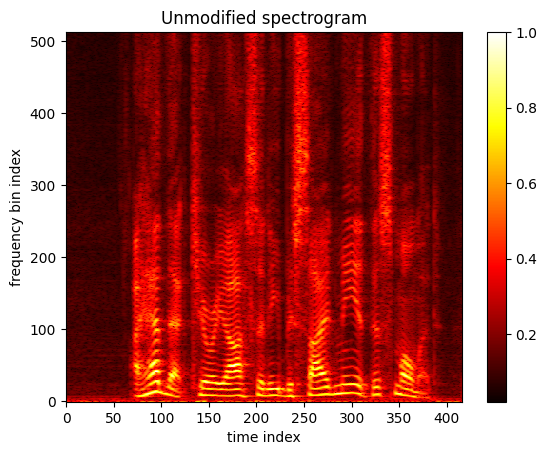

In [ ]:
imshow(magnitude[0].T**0.125, origin='lower', cmap=cm.hot, aspect='auto', interpolation='nearest')
colorbar()
title('Unmodified spectrogram')
xlabel('time index')
ylabel('frequency bin index')

Text(0, 0.5, 'mel frequency index')

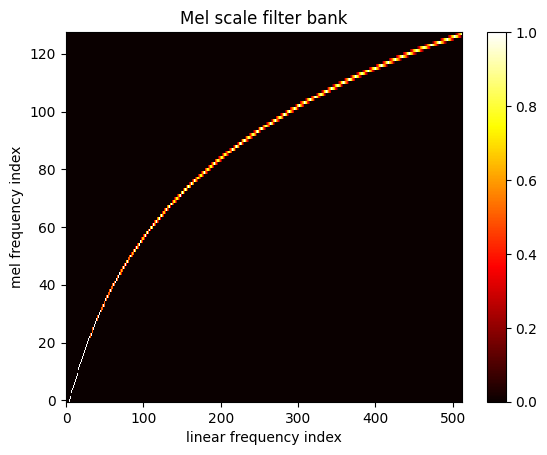

In [ ]:
imshow(filterbank[0], origin='lower', cmap=cm.hot, aspect='auto', interpolation='nearest')
colorbar()
title('Mel scale filter bank')
xlabel('linear frequency index')
ylabel('mel frequency index')

In [ ]:
for i in range(mel_spec.shape[0]):
  print(mel_spec[i].min(), mel_spec[i].max(), (mel_spec[i]**0.125).min(), (mel_spec[i]**0.125).max())

tensor(0., dtype=torch.float64) tensor(1.2885, dtype=torch.float64) tensor(0., dtype=torch.float64) tensor(1.0322, dtype=torch.float64)
tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64) tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)
tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64) tensor(0., dtype=torch.float64) tensor(1., dtype=torch.float64)
tensor(0., dtype=torch.float64) tensor(1.2885, dtype=torch.float64) tensor(0., dtype=torch.float64) tensor(1.0322, dtype=torch.float64)
tensor(0., dtype=torch.float64) tensor(1.2885, dtype=torch.float64) tensor(0., dtype=torch.float64) tensor(1.0322, dtype=torch.float64)


Text(0, 0.5, 'mel frequency bin index')

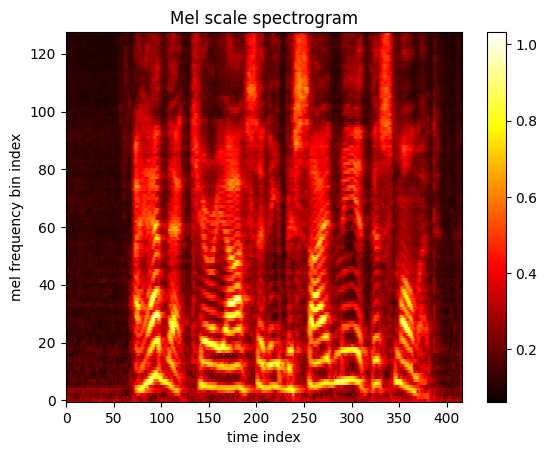

In [ ]:
imshow(mel_spec[0]**0.125, origin='lower', cmap=cm.hot, aspect='auto', interpolation='nearest')
colorbar()
title('Mel scale spectrogram')
xlabel('time index')
ylabel('mel frequency bin index')

Text(0, 0.5, 'frequency bin index')

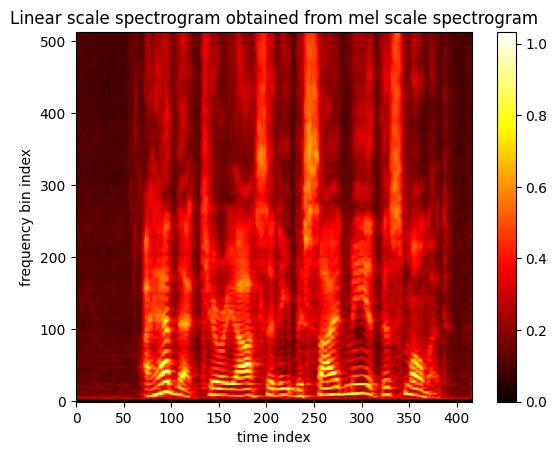

In [ ]:
imshow(inv_linear_spec[0]**0.125, origin='lower', cmap=cm.hot, aspect='auto', interpolation='nearest')
colorbar()
title('Linear scale spectrogram obtained from mel scale spectrogram')
xlabel('time index')
ylabel('frequency bin index')

<ipython-input-108-df79f4d63feb>:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  imshow(stft_modified.T**0.125, origin='lower', cmap=cm.hot, aspect='auto', interpolation='nearest')


Text(0, 0.5, 'frequency bin index')

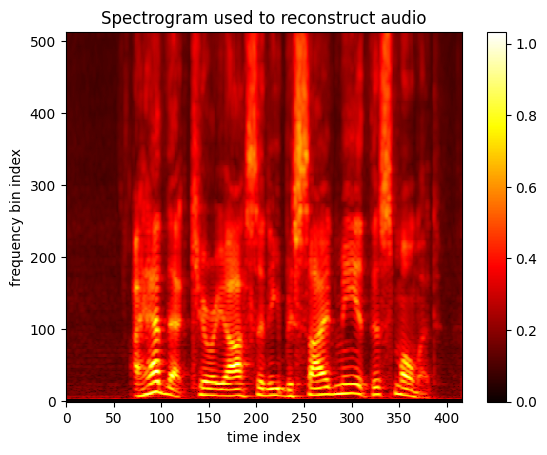

In [ ]:
imshow(stft_modified.T**0.125, origin='lower', cmap=cm.hot, aspect='auto', interpolation='nearest')
colorbar()
title('Spectrogram used to reconstruct audio')
xlabel('time index')
ylabel('frequency bin index')

In [ ]:
# def run_demo_batch(args):
#   in_file = args.in_file

#   # LOAD WAV
#   input_signal_torch = get_signal_torch(in_file, expected_fs=16000) # input_signal_torch.shape torch.Size([54400])
#   input_signal_torch = input_signal_torch.unsqueeze(0) # input_signal_torch.shape torch.Size([N, 54400])
#   batch = input_signal_torch.shape[0]

#   hopsamp = args.fft_size // 8

#   stft_full_torch = stft_for_reconstruction_batch(input_signal_torch, args.fft_size, hopsamp) # stft_full_torch.shape torch.Size([N, 417, 513])

#   stft_mag_torch = torch.abs(stft_full_torch)**2.0 # stft_mag_torch.shape torch.Size([N, 417, 513])

#   scale_torch = 1.0 / torch.max(stft_mag_torch.view(stft_mag_torch.shape[0], -1), dim=1).values # scale_torch.shape torch.Size([N])
#   print('Maximum value in the magnitude spectrogram: ', 1/scale_torch, scale_torch.max(), scale_torch.min())

#   # Rescale to put all values in the range [0, 1].
#   for b in range(batch):
#     stft_mag_torch[b] *= scale_torch[b] # stft_mag_torch.shape torch.Size([N, 417, 513])

#   if args.enable_mel_scale:
#       min_freq_hz = 70
#       max_freq_hz = 8000
#       mel_bin_count = 128 #200

#       linear_bin_count = 1 + args.fft_size//2
#       filterbank_torch = make_mel_filterbank_batch(min_freq_hz, max_freq_hz, mel_bin_count, linear_bin_count , args.sample_rate_hz)

#       mel_spectrogram_torch = torch.matmul(filterbank_torch, stft_mag_torch.permute(0, 2, 1))

#       inverted_mel_to_linear_freq_spectrogram_torch = torch.matmul(filterbank_torch.permute(0, 2, 1), mel_spectrogram_torch)

#       stft_modified_torch = inverted_mel_to_linear_freq_spectrogram_torch.permute(0, 2, 1)
#   else:
#       stft_modified_torch = stft_mag_torch

#   # Undo the rescaling.
#   stft_modified_scaled_torch = torch.zeros_like(stft_modified_torch)
#   for b in range(batch):
#     stft_modified_scaled_torch[b] = torch.pow(stft_modified_torch[b] / scale_torch[b], 0.5)

#   x_reconstruct_torch = reconstruct_signal_griffin_lim_batch(stft_modified_scaled_torch, args.fft_size, hopsamp, args.iterations)
#   x_reconstruct_torch = change_range(norm(x_reconstruct_torch))

#   sf.write('test/out99.wav', x_reconstruct_torch[0].numpy(), args.sample_rate_hz[0])

#   return stft_full_torch, stft_mag_torch, scale_torch, filterbank_torch, mel_spectrogram_torch, inverted_mel_to_linear_freq_spectrogram_torch, stft_modified_torch, stft_modified_scaled_torch, x_reconstruct_torch

### griffin_lim/ get result

In [ ]:
class Arg:
  in_file = 'sample.wav'
  sample_rate_hz = [16000]
  fft_size = 1024
  iterations = 300
  enable_filter = False
  enable_mel_scale = True
  cutoff_freq = 300
  hopsamp = fft_size // 8

args = Arg()
# run_demo_batch(args)

## DRAFT

In [ ]:
wav, sr = SPEECH_WAVEFORM.detach().clone(), SAMPLE_RATE
wav.shape, sr

(torch.Size([1, 54400]), 16000)

In [ ]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128
sr = 16000
n_stft = int((n_fft//2) + 1)

mel_transform = T.MelSpectrogram(
    sample_rate=sr,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode='reflect',
    power=2.0,
    # normalized=True,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)
inv_transform = T.InverseMelScale(#sample_rate=sample_rate, n_stft=n_stft
    sample_rate=sample_rate,
    n_stft=n_stft,
    n_mels=n_mels,
    mel_scale='htk',
    max_iter=100
)
grifflim_transform = T.GriffinLim(
    n_fft=n_fft,
    win_length=win_length,
    power=2.0
)
# inv_spec = T.InverseSpectrogram(
#     n_fft = n_fft,
#     win_length=win_length,
#     hop_length=hop_length,
#     pad = 0,
#     normalized = True,
#     wkwargs = None,
#     center = True,
#     pad_mode = "reflect",
#     onesided = True,
# )

M = librosa.feature.melspectrogram(
    y=wav.numpy(), # SPEECH_WAVEFORM.numpy().shape = (1, 54400)
    sr=sr,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels=n_mels,
    norm="slaney",
    htk=True,
)
S = librosa.feature.inverse.mel_to_audio(
    M=M,
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode='reflect',
    power=2.0,
    # n_mels=n_mels,
    norm='slaney',
    htk=True,
)

/usr/local/lib/python3.10/dist-packages/torchaudio/transforms/_transforms.py:611: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


In [ ]:
melspec = mel_transform(wav)
mel_spec_inv = inv_transform(melspec.detach().clone())
pseudo_wav = grifflim_transform(mel_spec_inv)
print(melspec.shape, M.shape, (melspec.numpy() - M).sum(), (pseudo_wav.numpy() - S).sum())

torch.Size([1, 128, 107]) (1, 128, 107) -0.00086280995 10.692408


In [ ]:
Audio(pseudo_wav, rate=sr)

In [ ]:
Audio(S, rate=sr)

### attemp convert librosa to torch
1. librosa.feature.melspectrogram [src](https://librosa.org/doc/latest/_modules/librosa/feature/spectral.html#melspectrogram) (== T.MelSpectrogram)
1. librosa.feature.inverse.mel_to_audio [src](https://librosa.org/doc/main/_modules/librosa/feature/inverse.html#mel_to_audio)
  * Code:
    ```python
      S = librosa.feature.inverse.mel_to_stft(M)
      y = librosa.griffinlim(S)
    ```
  1. librosa.feature.inverse.mel_to_stft ([src](https://librosa.org/doc/main/generated/librosa.feature.inverse.mel_to_stft.html#librosa.feature.inverse.mel_to_stft_))
    * filters.mel ([src](https://librosa.org/doc/latest/generated/librosa.filters.mel.html))
        * fft_frequencies ([src](https://librosa.org/doc/latest/generated/librosa.fft_frequencies.html))
        * mel_frequencies ([src](https://librosa.org/doc/latest/generated/librosa.mel_frequencies.html))
            * hz_to_mel ([src](https://librosa.org/doc/latest/_modules/librosa/core/convert.html#hz_to_mel))
            * mel_to_hz ([src](https://librosa.org/doc/latest/_modules/librosa/core/convert.html#mel_to_hz))
    * nnls ([src](https://librosa.org/doc/main/_modules/librosa/util/_nnls.html#nnls))
        * _nnls_lbfgs_block ([src](https://librosa.org/doc/main/_modules/librosa/util/_nnls.html))
  1. librosa.griffinlim ([src](https://librosa.org/doc/latest/_modules/librosa/core/spectrum.html#griffinlim)) (== T.GriffinLim)

### librosa.feature.inverse.mel_to_stft

In [ ]:
from typing import Any, Sequence, Tuple
import scipy

def mel_to_stft(
    M: np.ndarray,
    *,
    sr: float = 22050,
    n_fft: int = 2048,
    power: float = 2.0,
    **kwargs: Any,
) -> np.ndarray:
    # Construct a mel basis with dtype matching the input data
    mel_basis = filters.mel(
        sr=sr, n_fft=n_fft, n_mels=M.shape[-2], dtype=M.dtype, **kwargs
    )

    # Find the non-negative least squares solution, and apply
    # the inverse exponent.
    # We'll do the exponentiation in-place.
    inverse = nnls(mel_basis, M)
    return np.power(inverse, 1.0 / power, out=inverse)

def nnls(A: np.ndarray, B: np.ndarray, **kwargs: Any) -> np.ndarray:
    # If B is a single vector, punt up to the scipy method
    if B.ndim == 1:
        return scipy.optimize.nnls(A, B)[0]  # type: ignore

    MAX_MEM_BLOCK = 2**8 * 2**10 # https://librosa.org/doc/latest/_modules/librosa/util/utils.html
    n_columns = int(MAX_MEM_BLOCK // (np.prod(B.shape[:-1]) * A.itemsize))
    n_columns = max(n_columns, 1)

    # Process in blocks:
    if B.shape[-1] <= n_columns:
        return _nnls_lbfgs_block(A, B, **kwargs).astype(A.dtype)

    x: np.ndarray
    x = np.einsum("fm,...mt->...ft", np.linalg.pinv(A), B, optimize=True)
    np.clip(x, 0, None, out=x)
    x_init = x

    for bl_s in range(0, x.shape[-1], n_columns):
        bl_t = min(bl_s + n_columns, B.shape[-1])
        x[..., bl_s:bl_t] = _nnls_lbfgs_block(
            A, B[..., bl_s:bl_t], x_init=x_init[..., bl_s:bl_t], **kwargs
        )
    return x

def _nnls_lbfgs_block(
    A: np.ndarray, B: np.ndarray, x_init: Optional[np.ndarray] = None, **kwargs: Any
) -> np.ndarray:
    # If we don't have an initial point, start at the projected
    # least squares solution
    if x_init is None:
        # Suppress type checks because mypy can't find pinv
        x_init = np.einsum("fm,...mt->...ft", np.linalg.pinv(A), B, optimize=True)
        np.clip(x_init, 0, None, out=x_init)

    # Adapt the hessian approximation to the dimension of the problem
    kwargs.setdefault("m", A.shape[1])

    # Construct non-negative bounds
    bounds = [(0, None)] * x_init.size
    shape = x_init.shape

    # optimize
    x: np.ndarray
    x, obj_value, diagnostics = scipy.optimize.fmin_l_bfgs_b(
        _nnls_obj, x_init, args=(shape, A, B), bounds=bounds, **kwargs
    )
    # reshape the solution
    return x.reshape(shape)

def _nnls_obj(
    x: np.ndarray, shape: Sequence[int], A: np.ndarray, B: np.ndarray
) -> Tuple[float, np.ndarray]:
    """Compute the objective and gradient for NNLS"""
    # Scipy's lbfgs flattens all arrays, so we first reshape
    # the iterate x
    x = x.reshape(shape)

    # Compute the difference matrix
    diff = np.einsum("mf,...ft->...mt", A, x, optimize=True) - B

    # Compute the objective value
    value = (1 / B.size) * 0.5 * np.sum(diff**2)

    # And the gradient
    grad = (1 / B.size) * np.einsum("mf,...mt->...ft", A, diff, optimize=True)

    # Flatten the gradient
    return value, grad.flatten()

### librosa.feature.melspectrogram & librosa.griffinlim

In [ ]:
# librosa.griffinlim == T.GriffinLim
x1 = librosa.griffinlim(
    mel_spec_inv.detach().clone().numpy(),
    hop_length=hop_length,
    win_length=win_length,
    n_fft=n_fft,
    window='hann',
    center=True,
    pad_mode='reflect'
)
grifflim = T.GriffinLim(
    win_length=win_length,
    hop_length=hop_length,
    n_fft=n_fft,
    # window_fn=torch.hann_window(n_fft) default = torch.hann_window
)
x2 = grifflim(mel_spec_inv.detach().clone())
x1.shape, x2.shape, (x1 - x2.numpy()).sum()

((1, 54272), torch.Size([1, 54272]), 10.430304)

In [ ]:
# librosa.feature.melspectrogram == T.MelSpectrogram
x1 = librosa.stft(
    wav.numpy(),
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    window='hann',
    center=True,
    pad_mode='reflect'
)
x2 = torch.stft(
    wav.detach().clone(),
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    window=torch.hann_window(n_fft),
    center=True,
    return_complex=True
)
x1.shape, x2.shape, (x1 - x2.numpy()).sum()

((1, 513, 107), torch.Size([1, 513, 107]), (3.6658428e-05-2.13222e-05j))

### torchaudio.T

https://pytorch.org/audio/main/_modules/torchaudio/transforms/_transforms.html#MelSpectrogram

waveform -> melspec:
* spec = T.Spectrogram(waveform)
* melspec = T.MelScale(spec)
* or melspec = T.MelSpectrogram(waveform)

melspec -> waveform:
* spec = T.InverseMelScale(melspec)
* waveform = T.InverseSpectrogram(spec)
<!-- * T.InverseSpectrogram -->